In [8]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 분석할 폴더 경로
path = './results_OTresnet_ViT/Oct02_19-35-59'

# 특정 폴더의 피클 파일들을 불러오기
pickle_files = [f for f in os.listdir(path) if f.endswith('.pkl')]  # .pkl 확장자 파일들
pickle_files.sort()
for idx, p in enumerate(pickle_files):
    print('file {}:'.format(idx), p)


file 0: epoch_best_27.pkl
file 1: epoch_best_41.pkl
file 2: epoch_best_83.pkl


In [9]:
def load_pickle_and_convert_df(pickle_files):
    # 피클 파일들의 데이터를 데이터프레임으로 변환
    dataframes_dict = {}

    for file_name in pickle_files:
        file_path = os.path.join(path, file_name)  # 피클 파일 경로
        
        # 피클 파일 불러오기
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
        
        # 데이터가 리스트로 구성되어 있는지 확인 후 데이터프레임으로 변환
        df = pd.DataFrame(data)

        # expanded_df = pd.json_normalize(df)  # 각 행의 딕셔너리를 개별 컬럼으로 변환
        thresholds = np.linspace(0.001, 0.8, 500)
        df.insert(0, 'Thresholds', thresholds[:len(df)])
        
        dataframes_dict[file_name.split('.')[0]] = df  # 파일 이름을 키로 데이터프레임 리스트 저장
    return dataframes_dict

In [10]:
# Updated function to adjust the direction of the max value annotation arrow to point downward
def plot_metric_above_threshold(x_label, y_label, data, threshold=0.8):
    data_keys = list(data.keys())
    for key in data_keys:
        df = data[key]
        # Filtering data to include only F1-Score values above the threshold
        filtered_df = df[df[y_label] >= threshold]
        
        if not filtered_df.empty:
            plt.plot(filtered_df[x_label], filtered_df[y_label], marker='o', markersize=1, label=key)
            
            # Marking the max value on the y-axis within the filtered range
            max_value = filtered_df[y_label].max()
            max_index = filtered_df[y_label].idxmax()
            plt.axhline(y=max_value, color='r', linestyle='--', linewidth=0.5)
            plt.annotate(f'Max: {max_value:.2f}', 
                         xy=(filtered_df[x_label][max_index], max_value), 
                         xytext=(filtered_df[x_label][max_index], max_value - 0.05),  # Arrow pointing downward
                         arrowprops=dict(arrowstyle='->', lw=0.5))

    plt.title(y_label + "Values Above 0.8")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()  # Adding legend to indicate which line corresponds to which key
    plt.grid(True)
    plt.show()

In [11]:
def show_dataframe_structure(df: pd.DataFrame):
    """
    데이터프레임의 구조를 출력합니다.
    
    Args:
    df (pd.DataFrame): 분석할 데이터프레임
    
    Returns:
    None
    """
    print("데이터프레임의 구조:")
    print("열 이름:", df.columns.tolist())
    print("데이터 유형:\n", df.dtypes)
    print("데이터의 일부:\n", df.head())

In [12]:
metric_df = load_pickle_and_convert_df(pickle_files=pickle_files)
metric_df_keys = list(metric_df.keys())
for key in metric_df_keys:
    show_dataframe_structure(metric_df[key])

데이터프레임의 구조:
열 이름: ['Thresholds', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives', 'Precision', 'Recall (TPR)', 'F1-Score', 'Accuracy', 'False Positive Rate (FPR)', 'Top-5 Recall']
데이터 유형:
 Thresholds                   float64
True Positives                 int64
True Negatives                 int64
False Positives                int64
False Negatives                int64
Precision                    float64
Recall (TPR)                 float64
F1-Score                     float64
Accuracy                     float64
False Positive Rate (FPR)    float64
Top-5 Recall                 float64
dtype: object
데이터의 일부:
    Thresholds  True Positives  True Negatives  False Positives  \
0    0.001000               0            3478                0   
1    0.002601               0            3478                0   
2    0.004202               0            3478                0   
3    0.005804               0            3478                0   
4    0.007405            

epoch_best_27's Best F1-Score:	 0.9560155239327297, 	at thresholds: 0.3884909819639279
epoch_best_41's Best F1-Score:	 0.9673202614379085, 	at thresholds: 0.3804849699398798
epoch_best_83's Best F1-Score:	 0.9554390563564875, 	at thresholds: 0.3644729458917836


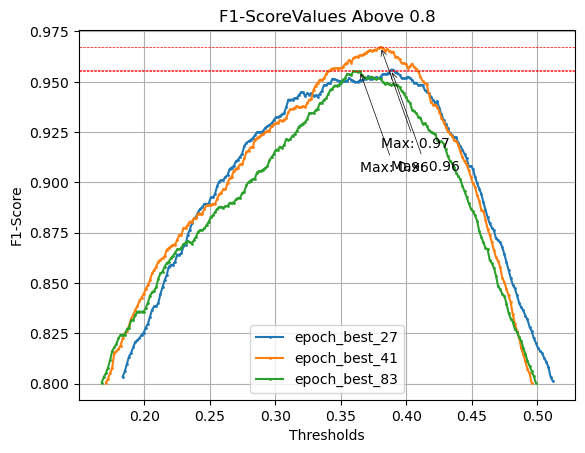

In [13]:
best_model = ''
best_f1_score = 0
# find and plot for f1max
for key in metric_df_keys:
    if isinstance(metric_df[key], list):
        df = metric_df[key][0]
    else:
        df = metric_df[key]
    max_f1_score = df["F1-Score"].max()
    if max_f1_score > best_f1_score:
        best_f1_score = max_f1_score
        best_model = key
    corresponding_threshold = df[df["F1-Score"] == max_f1_score]["Thresholds"].values[0]
    print(key + f"'s Best F1-Score:\t {max_f1_score}, \tat thresholds: {corresponding_threshold}")
plot_metric_above_threshold(x_label="Thresholds", y_label="F1-Score", data=metric_df)


In [14]:
# print best model at best threshold
best_df = metric_df[best_model]
best_f1_score = best_df["F1-Score"].max()
best_metric = best_df[best_df["F1-Score"] == best_f1_score]
print(f"Best Model: {best_model}, Best F1-Score: {best_f1_score}")
print(best_metric)

Best Model: epoch_best_41, Best F1-Score: 0.9673202614379085
     Thresholds  True Positives  True Negatives  False Positives  \
237    0.380485             740            3461               17   

     False Negatives  Precision  Recall (TPR)  F1-Score  Accuracy  \
237               33   0.977543      0.957309   0.96732  0.988238   

     False Positive Rate (FPR)  Top-5 Recall  
237                   0.004888      0.957309  
